---
title: A356 Lab 3 — Bayesian statistics 
subtitle: Fitting Galaxy Rotation Curves
authors:
  - name: Earl Patrick Bellinger
    orcid: 0000-0003-4456-4863
    affiliations:
      - Department of Astronomy, Yale University
license: CC-BY-4.0
---

*tags*: `bayes`, `model-fitting`, `optimization`, `sampling`, `mcmc`, `bayesian-evidence`, `data-visualization`, `interactive-visualizations`, `advanced-undergrad`

## Learning Goals 

In this lab, you will learn how to do: 
1. Interactive plotting with sliders 
2. Model fitting with optimization 
3. Bayesian posterior distribution estimations with MCMC sampling 
4. Evaluation of statistical evidence for dark matter 

## Overview

We appear to be in a Universe that is dominated by dark matter. By now there are many lines of evidence, but the earliest of these was the rotation curves of galaxies. Assuming Keplerian rotation, one expects the rotation velocity of galaxies to fall off at large radii. However, the observed rotation curves are flat. This situation can be rectified if we assume that there is a large "halo" of dark matter contributing enormous mass to the galaxy. Theoretical developments also lend support: cosmological models predict the large-scale structure of the Universe and the formation of realistic galaxies alike by assuming that the majority of mass in the Universe is dark. 

In this lab, we will investigate the evidence for dark matter. We will look at the rotation curve of a galaxy and fit velocity models to it. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.special import logsumexp

from ipywidgets import interact, FloatSlider # you will use interactive sliders in this exercise 

import emcee
import corner

np.random.seed(42) # for reproducibility 

In [2]:
# some statements to make the figures look nicer 
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 10, 
                     'ytick.labelsize': 10,
                     'axes.labelsize': 12,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6)
                    })

:::{tip} Exercise 1

NGC 3198 is a barred spiral galaxy in the constellation Ursa Major. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/NGC3198_-_SDSS_DR14_%28panorama%29.jpg/900px-NGC3198_-_SDSS_DR14_%28panorama%29.jpg" width="400" alt="NGC 3198 as viewewd by SDSS"/>

Measurements of its rotation curve from [Begeman (1989)](https://ui.adsabs.harvard.edu/abs/1989A%26A...223...47B/abstract) are available on canvas as `ngc3198.dat`.

The columns give the distance from the center of the galaxy in units of kpc, the circular velocity at the given radii, and the uncertainties on the measurements. 

Parse this data and plot it with errorbars. Make sure to label your axes properly!  
:::

<Table length=14>
   R      V_c    e_V_c 
float64 float64 float64
------- ------- -------
   0.25    55.0     8.0
    0.5    92.0     8.0
   0.75   110.0     6.0
    1.0   123.0     5.0
   1.25   134.0     4.0
    1.5   142.0     4.0
   1.75   145.0     3.0
    2.0   147.0     3.0
   2.25   148.0     3.0
    2.5   152.0     2.0
   2.75   155.0     2.0
    3.0   156.0     2.0
    3.5   157.0     2.0
    4.0   153.0     2.0


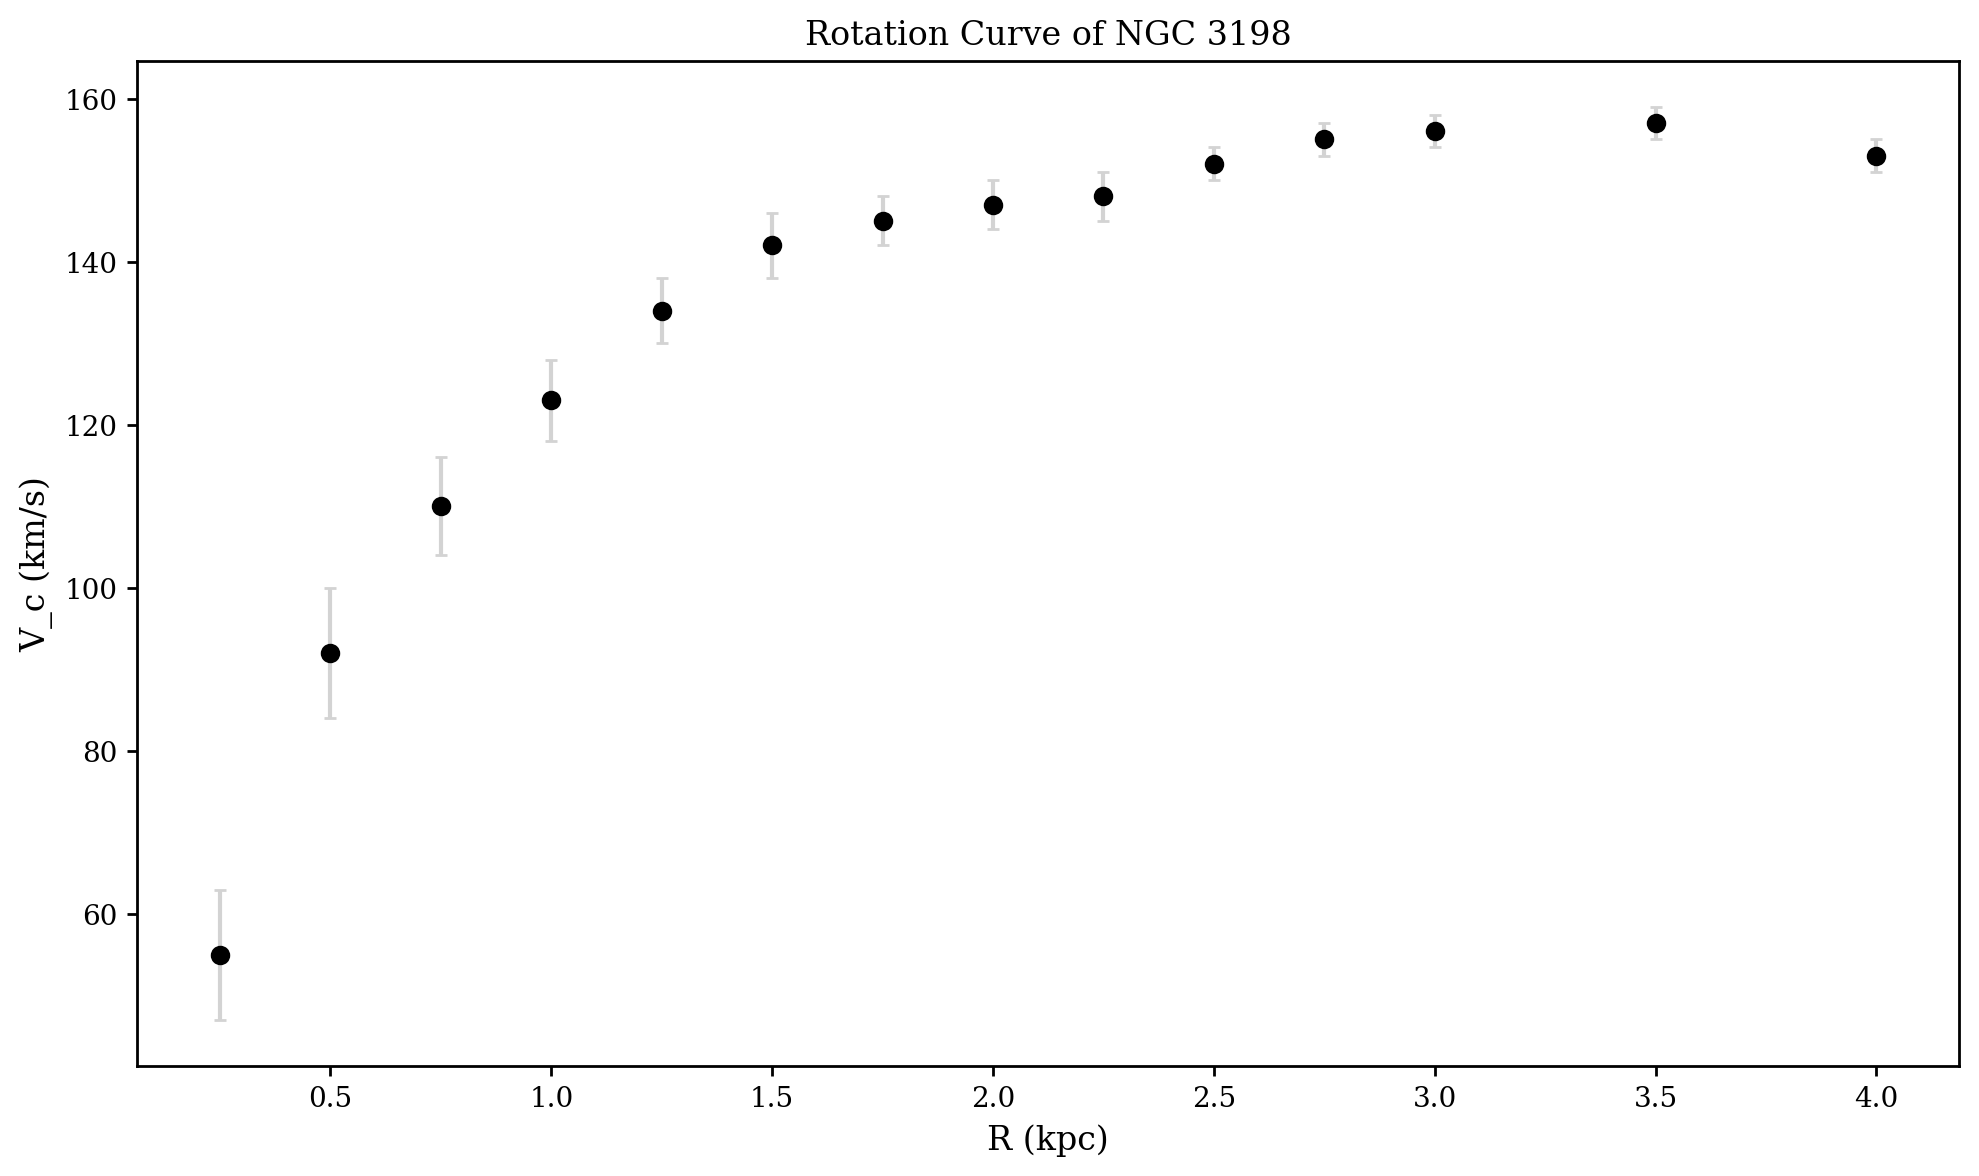

In [3]:
## Your code here

from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
import pprint


data = ascii.read('ngc3198.dat')
pprint.pp(data)

plt.errorbar(data['R'], data['V_c'], yerr = data['e_V_c'], fmt = 'o', color = 'black', ecolor = 'lightgray', capsize = 2, label = 'Data')
plt.xlabel('R (kpc)')
plt.ylabel('V_c (km/s)')
plt.title('Rotation Curve of NGC 3198')
plt.tight_layout()
plt.show()

:::{tip} Exercise 2

We consider a simplified model of the velocity profile of a galaxy's rotation curve, considering contributions from both the baryonic disk and the dark matter halo. 

The disk model, $V_{\textrm{disk}}(R)$, describes the rotational velocity contribution due to the galactic disk, assuming an exponential decrease in density with radius $R$. 

The halo model, $V_{\textrm{halo}}(R)$, accounts for the rotational velocity contribution from the dark matter halo, which dominates at larger radii.

The combined model, $V_{\textrm{total}}(R)$, represents the total rotational velocity by combining the contributions from both the disk and the halo components.

\begin{align*}
V_{\textrm{disk}}(R; V_d, R_d) &= V_d \left(\frac{R}{R_d}\right) \exp\left(-\frac{R}{R_d}\right) \\
V_{\textrm{halo}}(R; V_{\infty}, R_h) &= V_{\infty} \sqrt{1 - \left(\frac{R_h}{R}\right) \arctan\left(\frac{R}{R_h}\right)} \\
V_{\textrm{total}}(R) &= \sqrt{V_{\textrm{disk}}(R)^2 + V_{\textrm{halo}}(R)^2}
\end{align*}

Here:
- $R$ is the radial distance from the center of the galaxy.
- $V_d$ is the characteristic velocity scale of the disk.
- $R_d$ is the scale radius of the disk, where the exponential decline occurs.
- $V_{\infty}$ is the asymptotic velocity of the halo at large radii.
- $R_h$ is the core radius of the halo, marking the transition from the inner to the outer halo.

We can compare our model to the data using the reduced $\chi^2$ statistic:
\begin{equation}
    \chi^2 = 
    \frac{1}{N-k}
    \sum_{R_{\textrm{obs}}} 
        \frac{
            \left(
                V_{\textrm{total}}(R_{\textrm{obs}}) - V_\textrm{c}(R_{\textrm{obs}})
            \right)^2
        }{
            \sigma^2(R_{\textrm{obs}})
        }
\end{equation}
where $V_c$ is the observed velocity at the observed radii $R_{\textrm{obs}}$, $\sigma^2$ is the square of the given uncertainty, $N$ is the number of data points, and $k$ is the number of free parameters in our model (4). Smaller is better. Note that models with a reduced $\chi^2$ less than 1 cannot be distinguished by the data. 

1. Implement the disk, halo, and combined models as functions. 
2. Write a function that plots the models with the range $0<R<7$, along with the observed data, and indicate the $\chi^2$ of the fit. Give your function arguments to control the parameters of the models. 
3. Use ipython widgets to make sliders that allow you to visualize adjustments to the parameters of the model. The syntax is `interact(plot_rotation_curve, V_d=FloatSlider(min=0, max=500, step=1, value=100, description='V_d'), ...)`. Try to get a good fit by eye (it doesn't need to be perfect), and note down the values you get. 

**Hint 1**: The bodies of all four of these functions can be implemented in one line of python each. 

**Hint 2**: The velocities $V_d$, $V_{\infty}$ you find should be in the hundreds, and the radius components $R_d$, $R_h$ should be of order unity. 
:::

In [ ]:
## Your code here

from ipywidgets import interact, FloatSlider

def disk_model(R, V_d, R_d):
    return V_d * (R / R_d) * np.exp(-R / R_d)

# adapted halo_model so R=0 doesn't trigger divide-by-zero
def halo_model(R, V_inf, R_h):
    R = np.asarray(R, dtype=np.float64)
    safe_R = np.where(R == 0, 1e-6, R)
    term = 1.0 - (R_h / safe_R) * np.arctan(safe_R / R_h)
    term = np.clip(term, 0.0, None)
    return V_inf * np.sqrt(term)

def total_model(R, V_d, R_d, V_inf, R_h):
    return np.sqrt(disk_model(R, V_d, R_d) ** 2 + halo_model(R, V_inf, R_h) ** 2)


R = data['R']
V_c = data['V_c']
e_V_c = data['e_V_c']

def plot_rotation_curve(V_d, R_d, V_inf, R_h):

    Rs = np.linspace(0, 7, 100)

    V_total = total_model(Rs, V_d, R_d, V_inf, R_h)

    plt.errorbar(R, V_c, yerr=e_V_c, fmt='o', color='black', ecolor='lightgray', capsize=2, label='Data')

    plt.plot(Rs, V_total, color='red', label='Model')

    plt.xlabel('R (kpc)')
    plt.ylabel('V_c (km/s)')
    plt.title('Rotation Curve of NGC 3198 with model overlayed')
    plt.legend()
    plt.tight_layout()
    plt.show()



interact(plot_rotation_curve,
            V_d = FloatSlider(min=50, max=1000, step=1, value=226, description='V_d (km/s)'),
            R_d = FloatSlider(min=0.1, max=10, step=0.1, value=2.7, description='R_d (kpc)'),
            V_inf = FloatSlider(min=50, max=200, step=1, value=142, description='V_inf (km/s)'),
            R_h = FloatSlider(min=0.1, max=10, step=0.1, value=0.33, description='R_h (kpc)')
        )

interactive(children=(FloatSlider(value=226.0, description='V_d (km/s)', max=1000.0, min=50.0, step=1.0), Floa…

<function __main__.plot_rotation_curve(V_d, R_d, V_inf, R_h)>

:::{tip} Exercise 3 

This model is clearly non-linear (as there are for example terms inside an $\arctan$ function) and so we cannot use linear regression as in the previous lab. Hence we must rely on numerical optimization to find a good set of parameters. 

Find the maximum likelihood estimate for the model (and account for the uncertainties), i.e., the parameters that minimize $\chi^2$. Use `scipy.curve_fit` and supply the model, observations, uncertainities to that function. Call your plotting function with these fitted values. 

Best-fit parameters:
V_d: 226.80 km/s
R_d: 2.77 kpc
V_inf: 142.84 km/s
R_h: 0.33 kpc


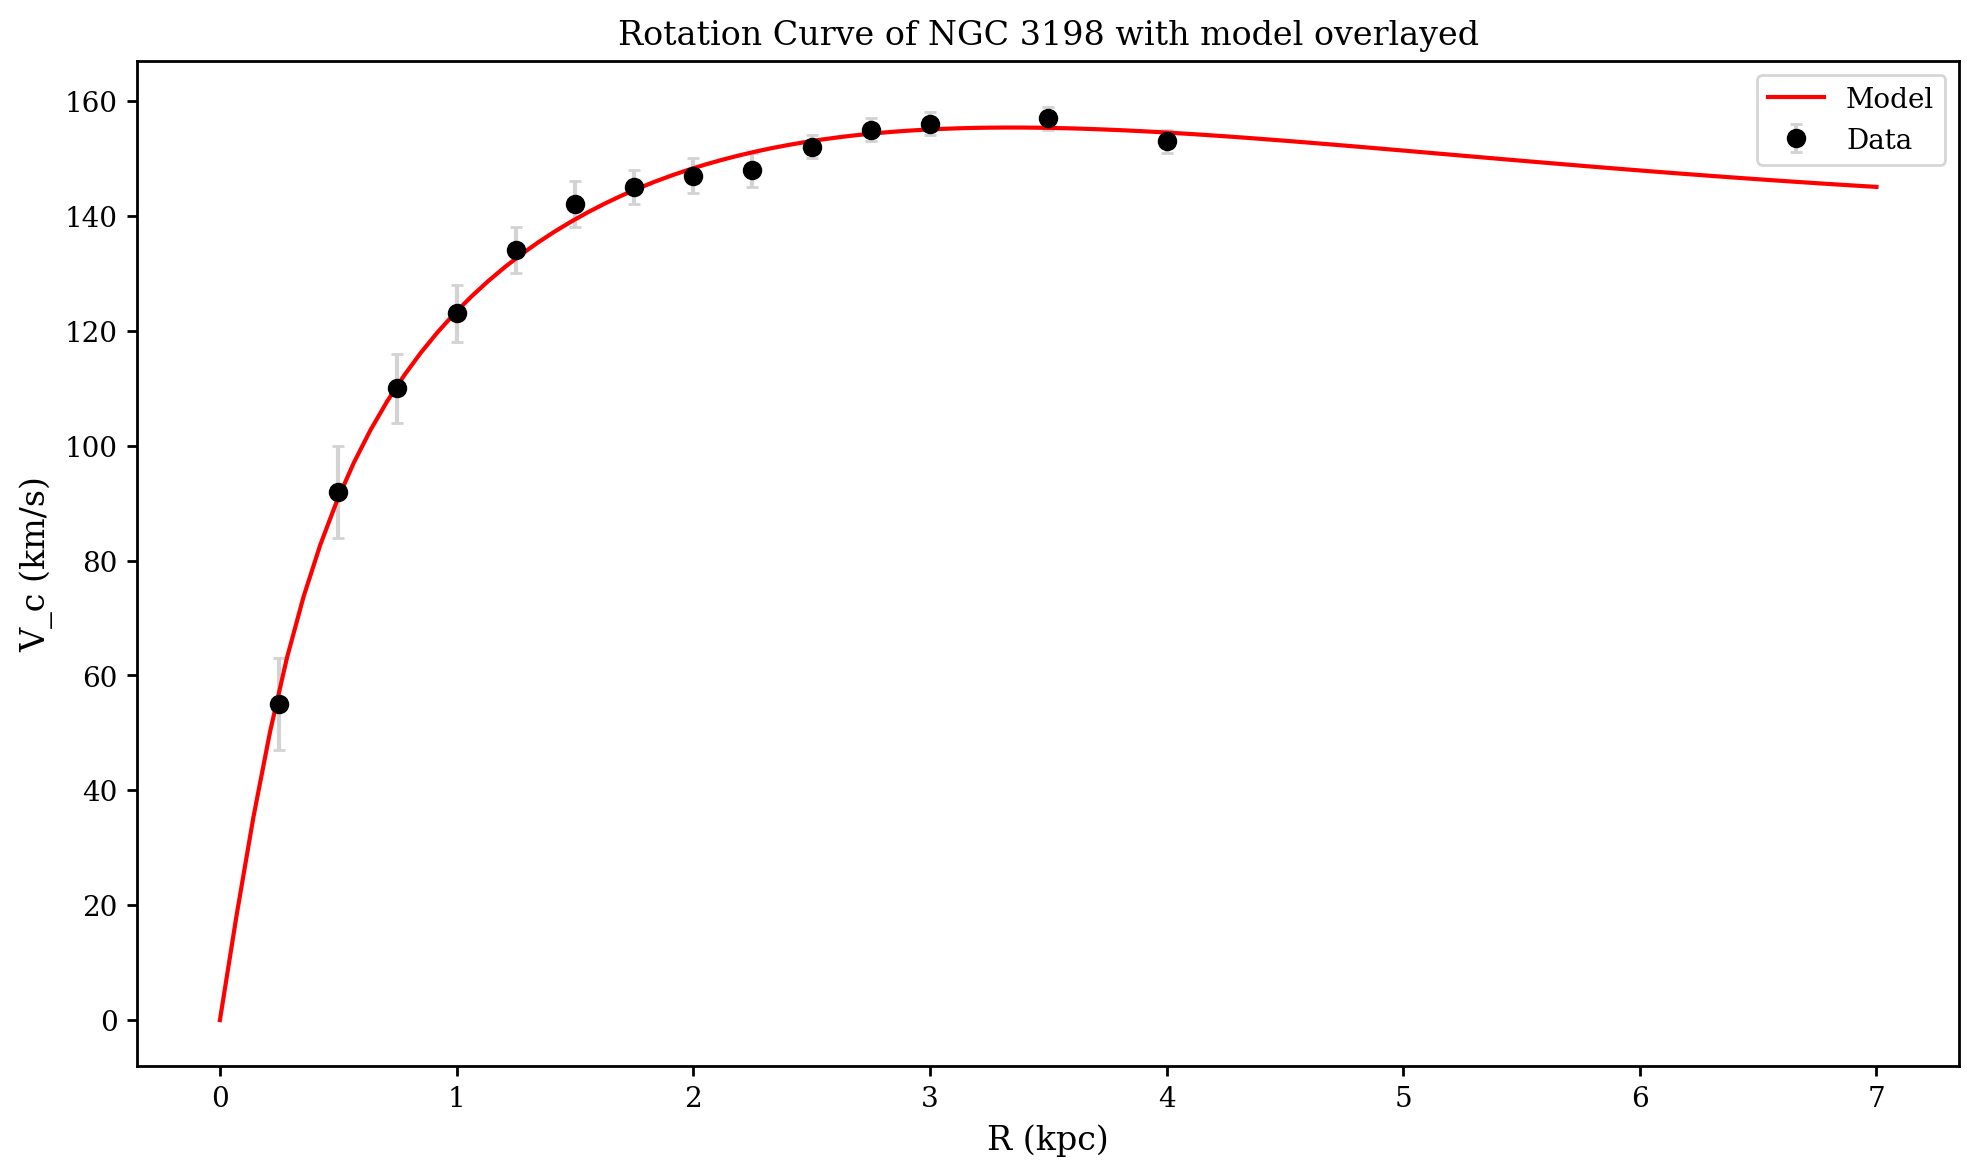

In [5]:
## Your code here

def chi_squared(params, R, V_c, e_V_c):
    V_d, R_d, V_inf, R_h = params
    V_model = total_model(R, V_d, R_d, V_inf, R_h)
    chi2 = np.sum(((V_c - V_model) / e_V_c) ** 2)
    return chi2
initial_guess = [100, 3, 100, 3]
best_params = curve_fit(total_model, R, V_c, sigma=e_V_c, p0=initial_guess, absolute_sigma=True)[0]
print("Best-fit parameters:")
print(f"V_d: {best_params[0]:.2f} km/s")
print(f"R_d: {best_params[1]:.2f} kpc")
print(f"V_inf: {best_params[2]:.2f} km/s")
print(f"R_h: {best_params[3]:.2f} kpc")
plot_rotation_curve(*best_params)

:::{tip} Exercise 4

Markov Chain Monte Carlo (MCMC) is a powerful method used in Bayesian statistics to sample from a probability distribution, particularly when direct sampling is difficult due to the complexity of the distribution. In the context of model fitting, MCMC allows us to explore the posterior distribution of model parameters given observed data, where the posterior is the probability of the model parameters given the data. By generating a chain of samples, MCMC provides a way to estimate the distribution of these parameters, accounting for both the likelihood of the data and any prior information we have about the parameters. 

In this exercise, you will use [`emcee`](https://emcee.readthedocs.io/en/stable/) to sample the log posterior distribution $\log P(\theta|\mathbf{D})$ of the galaxy rotation curve model parameters given the data, where I have used $\theta$ to denote the model parameters and $\mathbf{D}$ to denote the data. The posterior distribution is proportional to the product of the likelihood $\mathcal{L}(\mathcal{D}|\theta)$ and the prior $P(\theta)$, given below. We will assume a uniform prior distribution over a reasonable range of parameters. Similar to $\chi^2$ above, the likelihood function comes from the probability density function (pdf) of the [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) because we assume our errors to be normally distributed. 

\begin{align*}
\textrm{log likelihood}\; \log\mathcal{L}(\mathbf{D}|\theta) &= -\frac{1}{2} \sum_{R_\textrm{obs}} \left( \frac{(V_c(R_{\textrm{obs}}) - V_{\text{total}}(R_{\textrm{obs}}; \theta))^2}{\sigma^2(R_{\textrm{obs}})} + \log(2\pi \sigma^2(R_{\textrm{obs}})) \right) \\
\textrm{log prior:}\; \log P(\theta) &= 
    \begin{cases} 
        0.0 & \text{if } 0 < V_d < 1000, \, 0 < R_d < 20, \, 0 < V_{\infty} < 1000, \, 0 < R_h < 20 \\
        -\infty & \text{otherwise}
    \end{cases} \\
    \textrm{log posterior:}\; \log P(\theta|\mathbf{D}) &= \log\mathcal{L} + \log\Pi
\end{align*}

1. Draw 100,000 samples from the posterior distribution using 32 walkers. Seed the sampler with initial positions in a small ball around your maximum likelihood estimate. When you get the resulting chain, you can discard the first 50,000 samples as the "burn-in" period, and thin it by taking only every 100th sample (`sampler.get_chain(discard=50000, thin=100, flat=True)`). 
2. Plot the results using [`corner`](https://corner.readthedocs.io/en/latest/). Include quantiles and titles in the corner plot. Show the maximum likelihood estimate using the `truths` argument (even though they aren't really the true values, which are unknown and arguably unknowable). Set the axes ranges (via `ranges`) so that the results are clearly visible. 

The linked documentation for both of these modules are well worth reading through. 
:::

In [6]:
## Your code here

def log_prior(theta):
    V_d, R_d, V_inf, R_h = theta
    if 0 < V_d < 1000 and 0 < R_d < 20 and 0 < V_inf < 1000 and 0 < R_h < 20:
        return 0.0
    return -np.inf

def log_likelihood(theta, R, V_obs, e_V):
    model = total_model(R, *theta)
    if not np.all(np.isfinite(model)):
        return -np.inf
    return -0.5 * np.sum(((V_obs - model) / e_V) ** 2 + np.log(2 * np.pi * e_V ** 2))

def log_probability(theta, R, V_obs, e_V):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, R, V_obs, e_V)

best_params = np.asarray(best_params)
ndim, nwalkers, nsteps = len(best_params), 32, 100_000
pos = best_params * (1 + 1e-2 * np.random.randn(nwalkers, ndim))
pos = np.clip(pos, [1e-3, 1e-3, 1e-3, 1e-3], [999., 19.9, 999., 19.9])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(R, V_c, e_V_c))
sampler.run_mcmc(pos, nsteps, progress=True)

flat_samples = sampler.get_chain(discard=50000, thin=100, flat=True)
print("Mean acceptance fraction:", sampler.acceptance_fraction.mean())
print("Posterior sample shape:", flat_samples.shape)

100%|██████████| 100000/100000 [05:10<00:00, 322.39it/s]

Mean acceptance fraction: 0.3337821875
Posterior sample shape: (16000, 4)


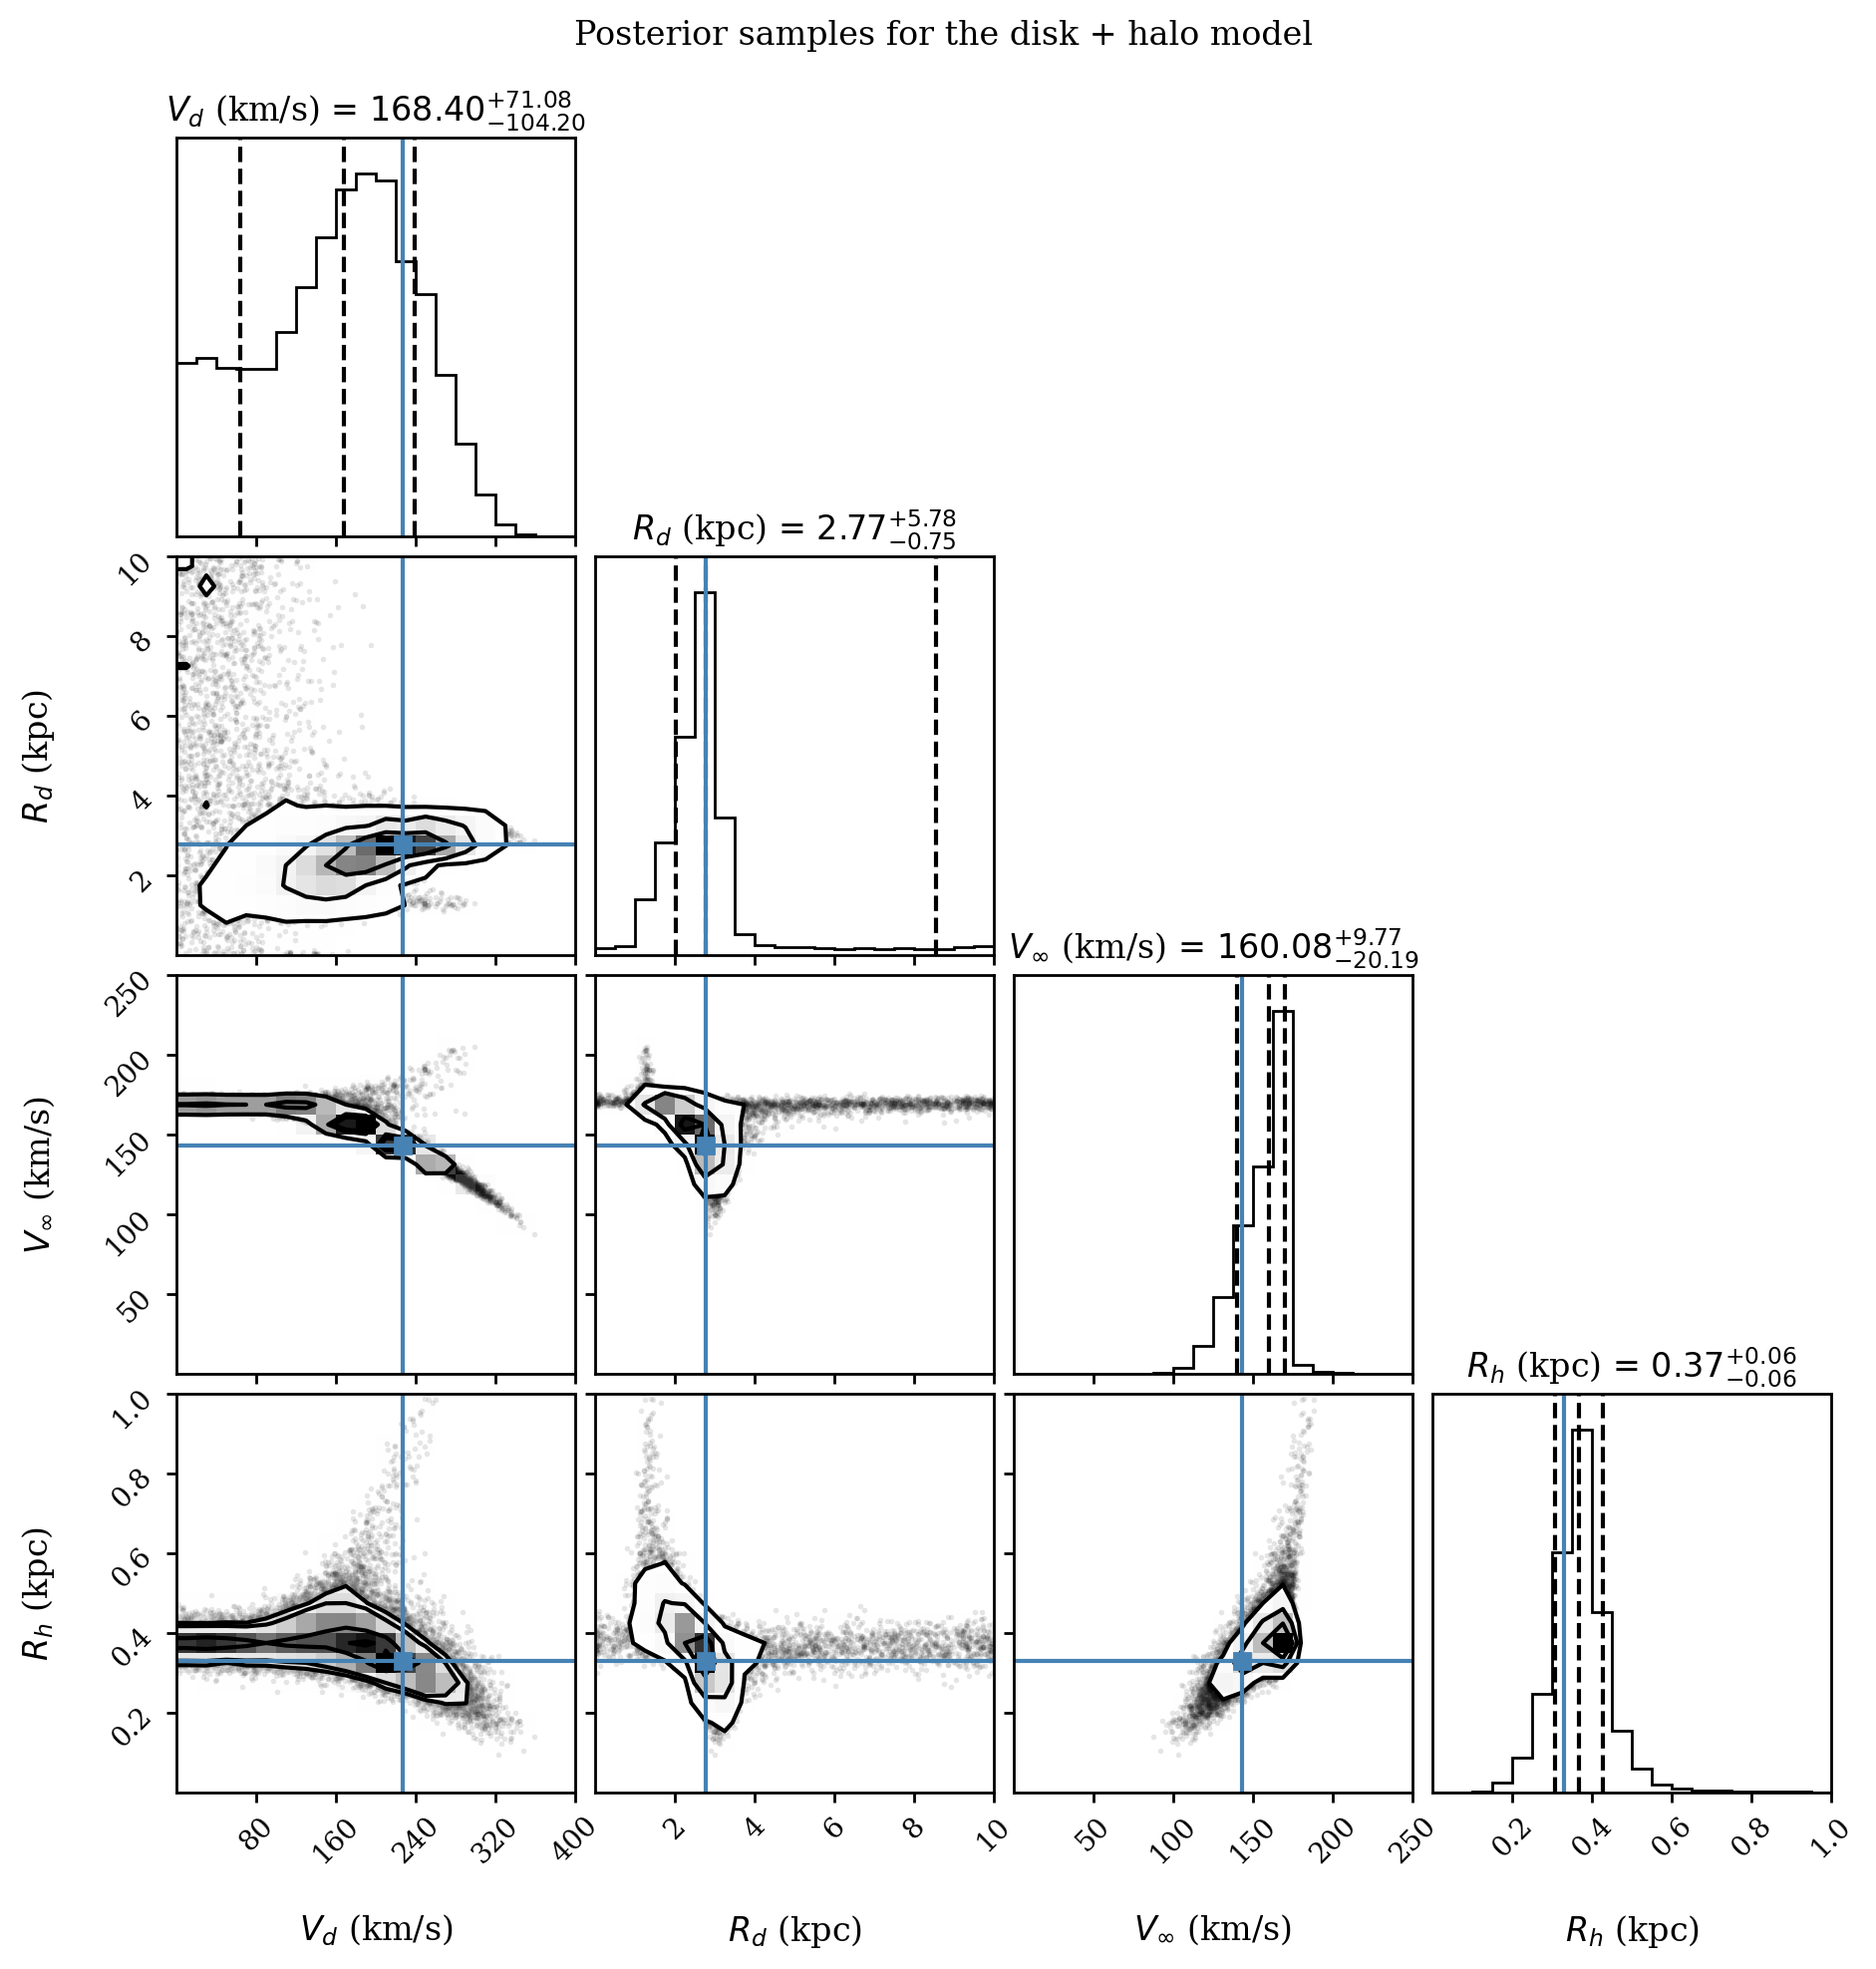

In [7]:
labels = [r"$V_d$ (km/s)", r"$R_d$ (kpc)", r"$V_\infty$ (km/s)", r"$R_h$ (kpc)"]
ranges = [(0, 400), (0,10), (0, 250), (0, 1)]

fig = corner.corner(
    flat_samples,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    truths=best_params,
    range=ranges,
)

fig.suptitle("Posterior samples for the disk + halo model", y=1.02)
plt.show()

:::{tip} Exercise 5

Compute the reduced $\chi^2$ for all your samples. Make a new `corner` plot of all your sampled parameters with it included, with the $\chi^2=1$ line indicated. Include the $\chi^2$ of your maximum likelihood model in the `truths` argument. 

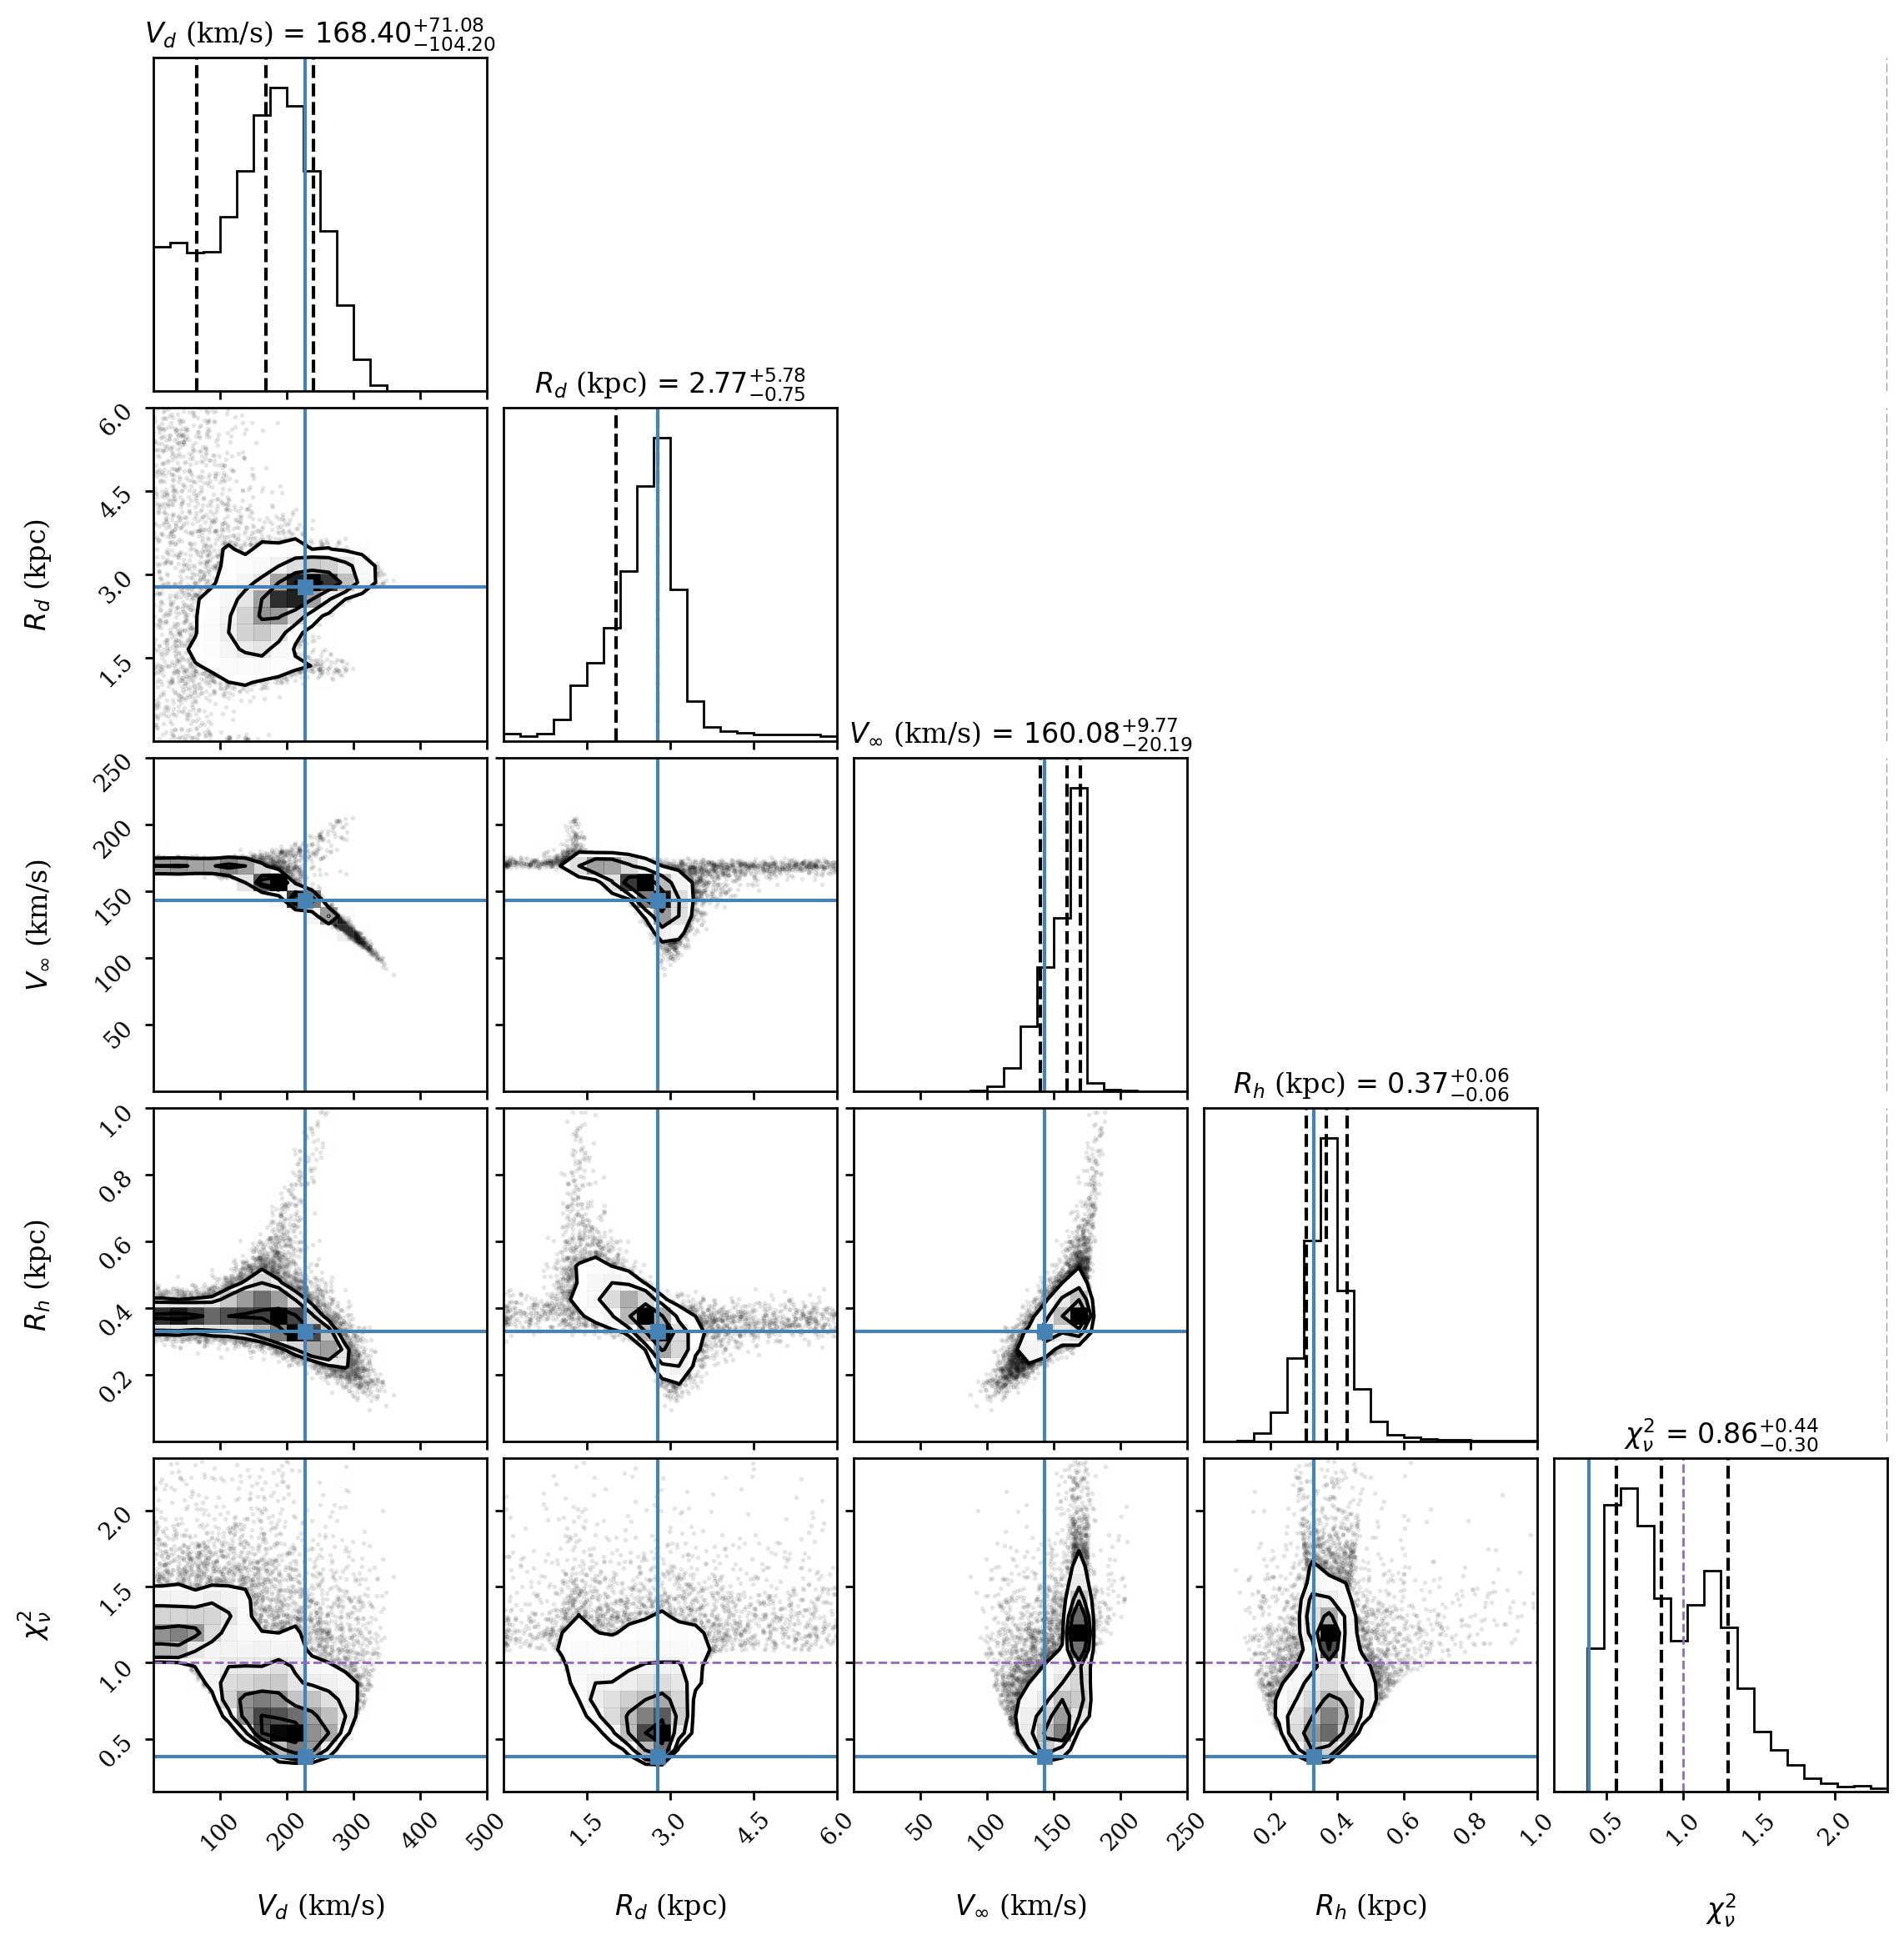

MLE reduced chi^2: 0.382


In [8]:
def chi_squared(theta):
    model = total_model(R, *theta)
    if not np.all(np.isfinite(model)):
        return np.inf
    return np.sum(((V_c - model) / e_V_c) ** 2)

chi2_samples = np.array([chi_squared(theta) for theta in flat_samples])
dof = len(R) - 4  # 4 free parameters in the disk+halo model
reduced_chi2_samples = chi2_samples / dof

chi2_mle = chi_squared(best_params)
reduced_chi2_mle = chi2_mle / dof

posterior_with_chi2 = np.column_stack([flat_samples, reduced_chi2_samples])

labels = [
    r"$V_d$ (km/s)",
    r"$R_d$ (kpc)",
    r"$V_\infty$ (km/s)",
    r"$R_h$ (kpc)",
    r"$\chi^2_\nu$",
]

chi2_low, chi2_high = np.percentile(reduced_chi2_samples, [0.5, 99.5])
chi2_pad = 0.15 * (chi2_high - chi2_low)
ranges = [
    (0, 500),
    (0,6),
    (0,250),
    (0,1),
    (max(0.0, chi2_low - chi2_pad), chi2_high + chi2_pad),
]

truths = np.append(best_params, reduced_chi2_mle)

fig = corner.corner(
    posterior_with_chi2,
    labels=labels,
    truths=truths,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    range=ranges,
)

ndim = posterior_with_chi2.shape[1]
axes = np.array(fig.axes).reshape((ndim, ndim))
chi2_target = 1.0

for ax in axes[:-1, -1]:
    ax.axvline(chi2_target, color="tab:purple", ls="--", lw=1)
for ax in axes[-1, :-1]:
    ax.axhline(chi2_target, color="tab:purple", ls="--", lw=1)
axes[-1, -1].axvline(chi2_target, color="tab:purple", ls="--", lw=1)

axes[-1, -1].set_xlabel(labels[-1])
plt.show()
print(f"MLE reduced chi^2: {reduced_chi2_mle:.3f}")

:::{tip} Exercise 5

Revisit your plots from earlier: now include 50 posterior samples of the model components. Choose from samples with $\chi^2\leq1$. 

Our fit was fine, but all of these models are equally fine! 
:::

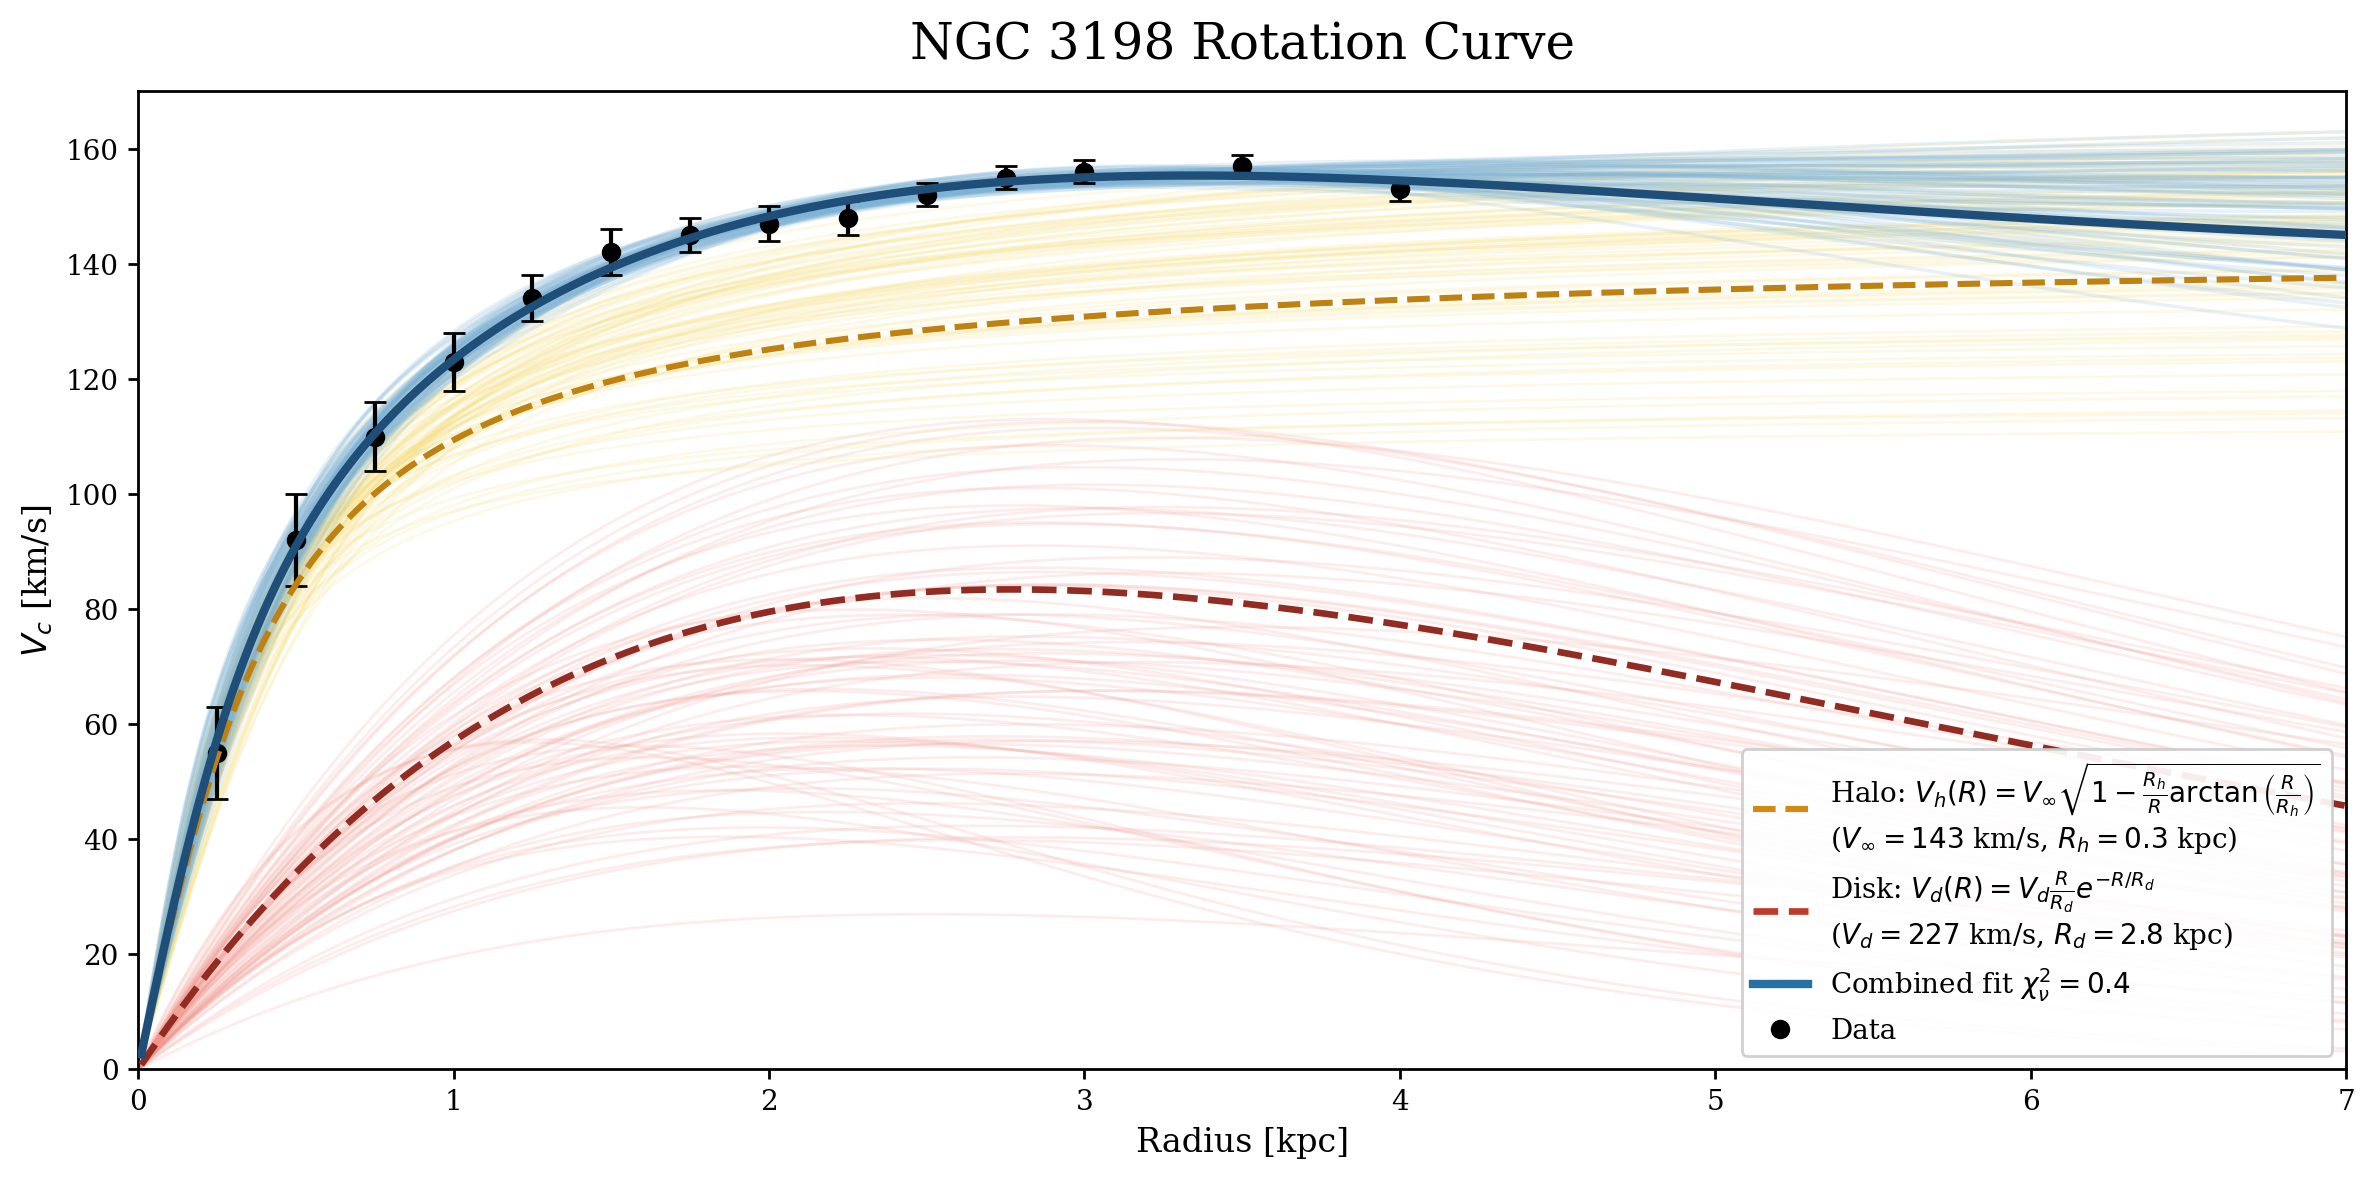

In [9]:
from matplotlib.lines import Line2D

rng = np.random.default_rng(42)

def plot_exercise5_style(samples, max_draws=80):
    eligible = samples[samples[:, -1] <= 1.0]
    if len(eligible) == 0:
        raise ValueError("No posterior samples satisfy χ²ν ≤ 1.")
    draw_count = min(max_draws, len(eligible))
    chosen = eligible[rng.choice(len(eligible), size=draw_count, replace=False)]

    Rs = np.linspace(0.01, 7.0, 400)

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.errorbar(
        R,
        V_c,
        yerr=e_V_c,
        fmt="o",
        color="black",
        ecolor="black",
        elinewidth=1.5,
        capsize=4,
        ms=6,
        label="Data",
    )

    pastel_total = "#7fb3d5"
    pastel_disk = "#f1948a"
    pastel_halo = "#f7dc6f"
    for V_d, R_d, V_inf, R_h, _ in chosen:
        disk_curve = disk_model(Rs, V_d, R_d)
        halo_curve = halo_model(Rs, V_inf, R_h)
        total_curve = np.sqrt(disk_curve ** 2 + halo_curve ** 2)

        ax.plot(Rs, total_curve, color=pastel_total, alpha=0.18, lw=1.2, zorder=1)
        ax.plot(Rs, disk_curve, color=pastel_disk, alpha=0.16, lw=1.0, zorder=0)
        ax.plot(Rs, halo_curve, color=pastel_halo, alpha=0.16, lw=1.0, zorder=0)

    Vd_mle, Rd_mle, Vinf_mle, Rh_mle = best_params
    mle_disk = disk_model(Rs, Vd_mle, Rd_mle)
    mle_halo = halo_model(Rs, Vinf_mle, Rh_mle)
    mle_total = np.sqrt(mle_disk ** 2 + mle_halo ** 2)

    halo_handle = Line2D([], [], color="#d68910", ls="--", lw=2.2,
        label=fr"Halo: $V_h(R)=V_\infty\sqrt{{1-\frac{{R_h}}{{R}}\arctan\left(\frac{{R}}{{R_h}}\right)}}$"
            f"\n($V_\infty={Vinf_mle:.0f}$ km/s, $R_h={Rh_mle:.1f}$ kpc)")
    disk_handle = Line2D([], [], color="#c0392b", ls="--", lw=2.4,
        label=fr"Disk: $V_d(R)=V_d\frac{{R}}{{R_d}}e^{{-R/R_d}}$"
            f"\n($V_d={Vd_mle:.0f}$ km/s, $R_d={Rd_mle:.1f}$ kpc)")
    total_handle = Line2D([], [], color="#2471a3", lw=3.0,
        label=rf"Combined fit $\chi^2_\nu={reduced_chi2_mle:.1f}$")
    data_handle = Line2D([], [], color="black", marker="o", lw=0, label="Data")

    ax.plot(Rs, mle_total, color="#1f4e79", lw=3.0, zorder=5)
    ax.plot(Rs, mle_disk, color="#922b21", lw=2.4, ls="--", zorder=4)
    ax.plot(Rs, mle_halo, color="#bf8210", lw=2.2, ls="--", zorder=4)

    ax.set_title("NGC 3198 Rotation Curve", fontsize=18, pad=12)
    ax.set_xlabel("Radius [kpc]")
    ax.set_ylabel(r"$V_c$ [km/s]")
    ax.set_xlim(0, 7)
    ax.set_ylim(0, 170)

    legend_handles = [halo_handle, disk_handle, total_handle, data_handle]
    ax.legend(handles=legend_handles, loc="lower right", frameon=True,
framealpha=0.92)

    plt.tight_layout()
    plt.show()

plot_exercise5_style(posterior_with_chi2)



:::{tip} Exercise 6 

We have done all of the above assuming by that there is a dark matter component of the galaxy. How well do we do with only a disk component? 

1. Do a MCMC simulation for the disk-only model. Seed it with a random small ball around a maximum likelihood estimate of the disk model. 
2. Make a corner plot including the $\chi^2$. Note that there are only two components, so $k=2$ in the reduced $\chi^2$ component.
3. Plot the maximum-likelihood disk-only model and 50 posterior samples. If there are no models with $\chi^2\leq1$ then sample from the posterior without a cut on $\chi^2$. 

In [10]:
# Disk-only maximum likelihood + MCMC
from scipy.optimize import curve_fit

def log_prior_disk(theta):
    V_d, R_d = theta
    if 0 < V_d < 1000 and 0 < R_d < 20:
        return 0.0
    return -np.inf

def log_likelihood_disk(theta, R, V_obs, e_V):
    V_d, R_d = theta
    model = disk_model(R, V_d, R_d)
    if not np.all(np.isfinite(model)):
        return -np.inf
    resid = (V_obs - model) / e_V
    return -0.5 * np.sum(resid**2 + np.log(2 * np.pi * e_V**2))

def log_probability_disk(theta, R, V_obs, e_V):
    lp = log_prior_disk(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_disk(theta, R, V_obs, e_V)

def chi_squared_disk(theta):
    model = disk_model(R, *theta)
    if not np.all(np.isfinite(model)):
        return np.inf
    return np.sum(((V_c - model) / e_V_c) ** 2)

disk_mle, _ = curve_fit(
    disk_model,
    R,
    V_c,
    sigma=e_V_c,
    p0=[best_params[0], best_params[1]],
    bounds=([1e-3, 1e-3], [1000.0, 20.0]),
    absolute_sigma=True,
)

ndim_disk, nwalkers_disk, nsteps_disk = 2, 32, 80_000
rng_disk = np.random.default_rng(123)
pos_disk = disk_mle * (1 + 1e-2 * rng_disk.normal(size=(nwalkers_disk, ndim_disk)))
pos_disk = np.clip(pos_disk, [1e-3, 1e-3], [999.0, 19.9])

sampler_disk = emcee.EnsembleSampler(
    nwalkers_disk,
    ndim_disk,
    log_probability_disk,
    args=(R, V_c, e_V_c),
)
sampler_disk.run_mcmc(pos_disk, nsteps_disk, progress=True)

disk_chain = sampler_disk.get_chain(discard=40_000, thin=50, flat=True)
disk_acceptance = sampler_disk.acceptance_fraction.mean()
disk_chi2_samples = np.array([chi_squared_disk(theta) for theta in disk_chain])
disk_chi2_mle = chi_squared_disk(disk_mle)
disk_reduced_chi2 = disk_chi2_samples / (len(R) - ndim_disk)
disk_reduced_chi2_mle = disk_chi2_mle / (len(R) - ndim_disk)

print(f"Disk-only MLE: V_d={disk_mle[0]:.2f} km/s, R_d={disk_mle[1]:.2f} kpc")
print(f"Mean acceptance fraction: {disk_acceptance:.3f}")
print(f"Posterior sample shape: {disk_chain.shape}")
print(f"MLE reduced chi^2: {disk_reduced_chi2_mle:.3f}")

100%|██████████| 80000/80000 [03:57<00:00, 336.38it/s]


Disk-only MLE: V_d=430.85 km/s, R_d=2.78 kpc
Mean acceptance fraction: 0.715
Posterior sample shape: (25600, 2)
MLE reduced chi^2: 6.588


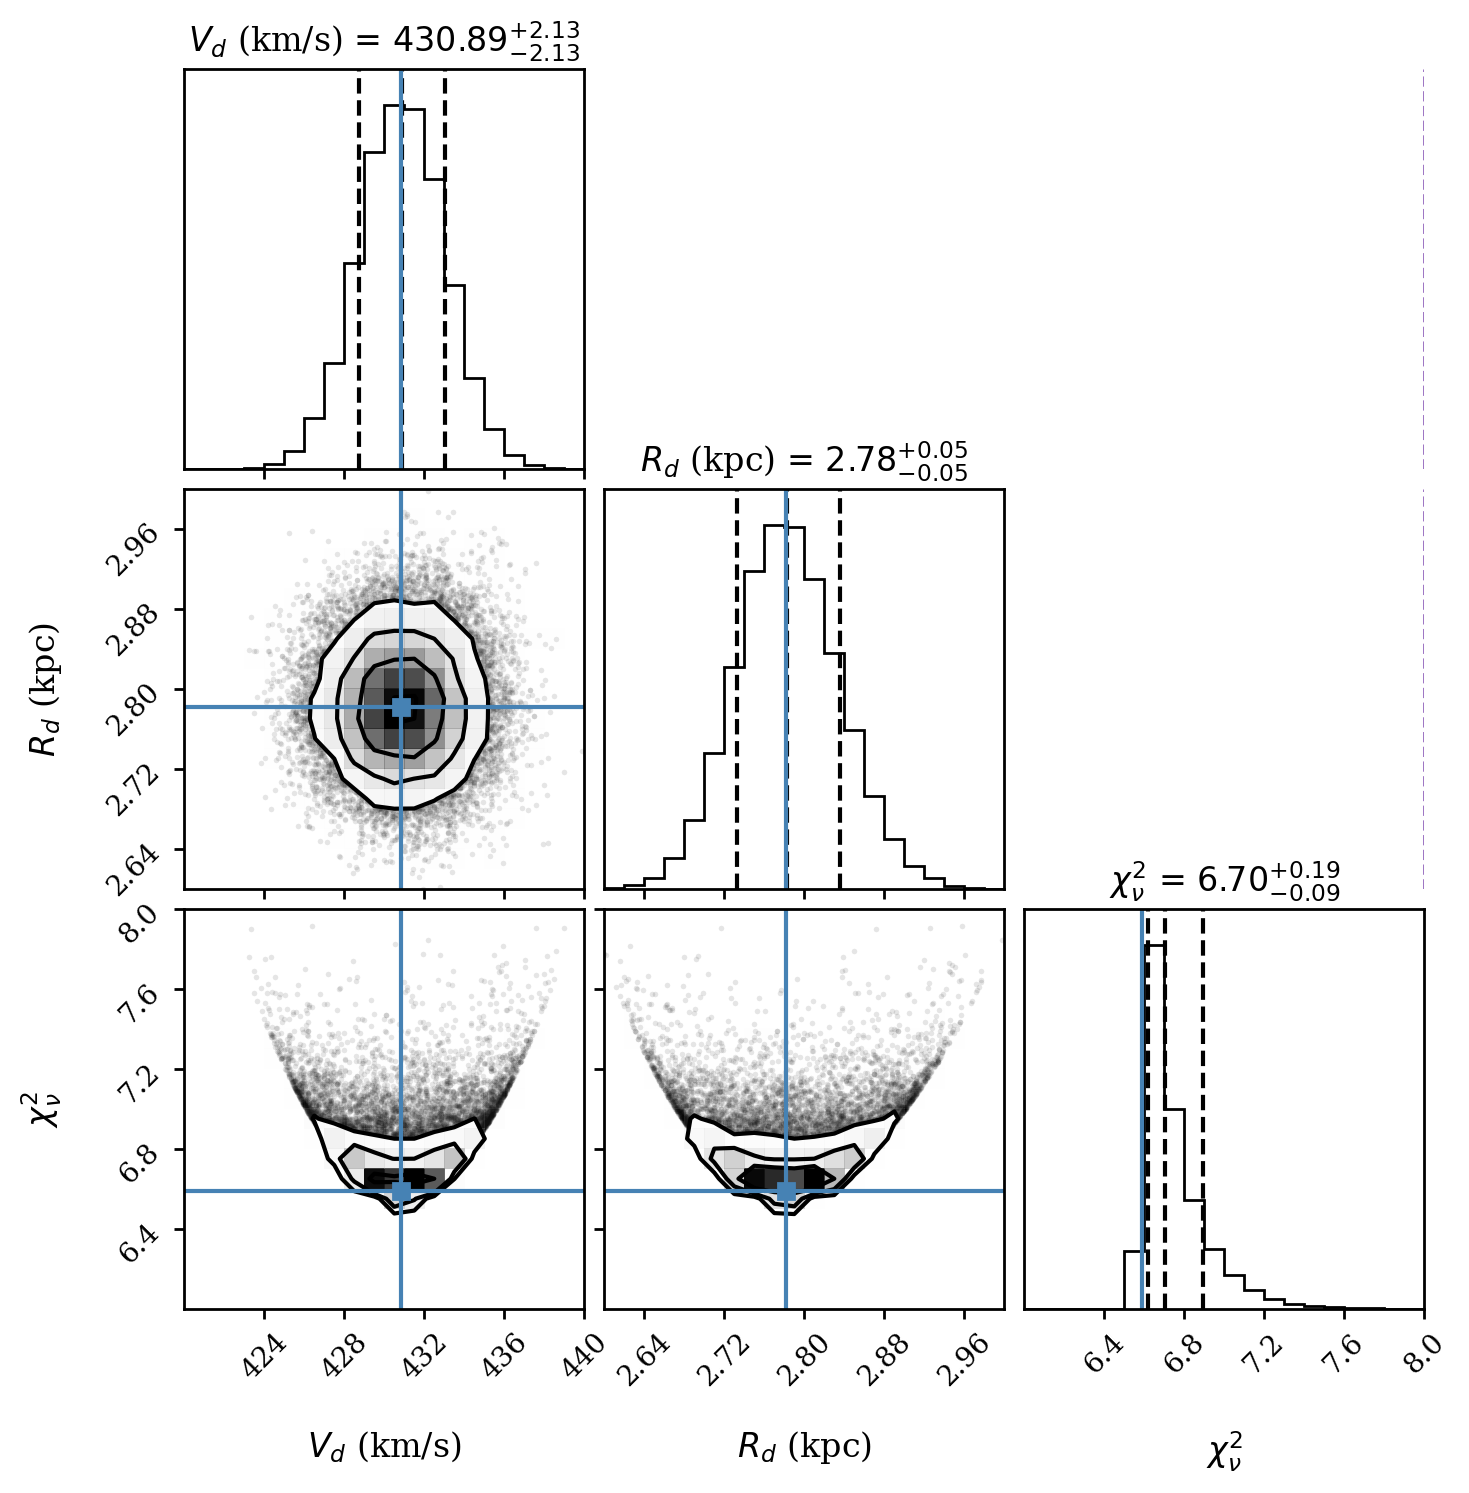

In [11]:
labels_disk = [r"$V_d$ (km/s)", r"$R_d$ (kpc)", r"$\chi^2_\nu$"]
disk_samples_with_chi2 = np.column_stack([disk_chain, disk_reduced_chi2])

ranges_disk = [
    (420,440),
    (2.6,3),
    (6,8),
]

truths_disk = np.append(disk_mle, disk_reduced_chi2_mle)

fig = corner.corner(
    disk_samples_with_chi2,
    labels=labels_disk,
    truths=truths_disk,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    range=ranges_disk,
)

axes = np.array(fig.axes).reshape((len(labels_disk), len(labels_disk)))
for ax in axes[:-1, -1]:
    ax.axvline(1.0, color="tab:purple", ls="--", lw=1)
for ax in axes[-1, :-1]:
    ax.axhline(1.0, color="tab:purple", ls="--", lw=1)
axes[-1, -1].axvline(1.0, color="tab:purple", ls="--", lw=1)

plt.show()

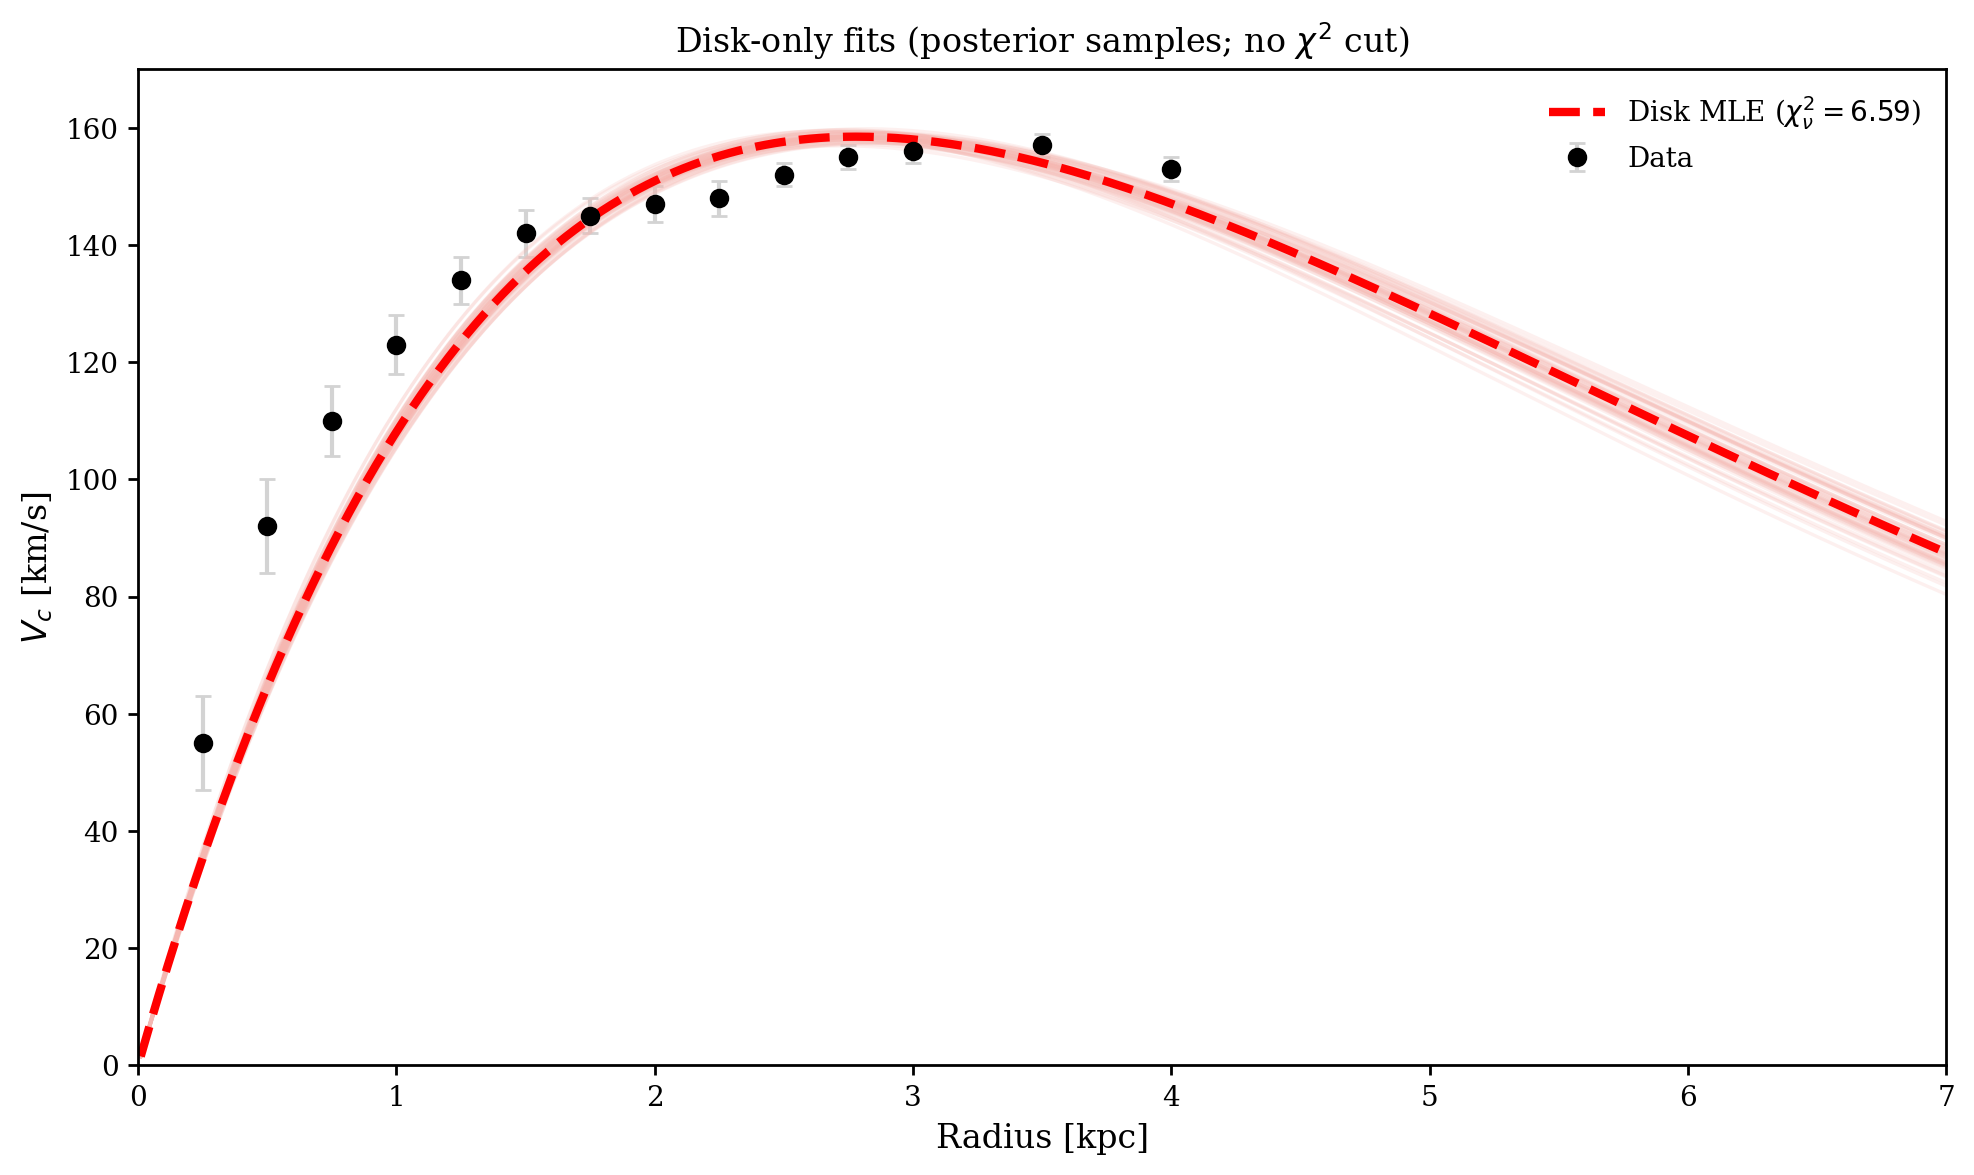

In [12]:
def plot_disk_only_curves(samples_with_chi2, mle_params, max_draws=50, chi2_cut=1.0):
    Rs = np.linspace(0.01, 7.0, 400)
    vals = samples_with_chi2[:, :2]
    chi2_vals = samples_with_chi2[:, -1]

    mask = chi2_vals <= chi2_cut
    if mask.any():
        chosen = vals[rng_disk.choice(np.where(mask)[0], size=min(max_draws,
mask.sum()), replace=False)]
        title_suffix = r"($\chi^2_\nu \le 1$)"
    else:
        chosen = vals[rng_disk.choice(len(vals), size=min(max_draws, len(vals)),
replace=False)]
        title_suffix = r"(posterior samples; no $\chi^2$ cut)"

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.errorbar(R, V_c, yerr=e_V_c, fmt="o", color="black", ecolor="lightgray",
capsize=3, label="Data")

    for V_d, R_d in chosen:
        ax.plot(Rs, disk_model(Rs, V_d, R_d), color="#f5b7b1", alpha=0.2, lw=1.2)

    ax.plot(
        Rs,
        disk_model(Rs, *mle_params),
        color="red",
        lw=3,
        ls="--",
        label=rf"Disk MLE ($\chi^2_\nu={disk_reduced_chi2_mle:.2f}$)",
    )

    ax.set_xlim(0, 7)
    ax.set_ylim(0, 170)
    ax.set_xlabel("Radius [kpc]")
    ax.set_ylabel(r"$V_c$ [km/s]")
    ax.set_title(f"Disk-only fits {title_suffix}")
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()

plot_disk_only_curves(disk_samples_with_chi2, disk_mle, max_draws=50, chi2_cut=1.0)



:::{tip} Exercise 7

The dark matter model outperforms the disk model, but also has two additional free parameters. One way to judge whether these additional free parameters are justified is through the Bayesian information criterion:
\begin{equation}
    \textrm{BIC} = k \log N - 2\log\mathcal{L}
\end{equation}
The BIC is a statistical tool used for model selection among a set of competing models. It balances the trade-off between the goodness of fit and model complexity by penalizing the inclusion of additional parameters. It approximates the Bayes factor, which is used to compare the posterior probabilities of different models. 

A lower BIC is better. When the difference of BICs between two models $|\delta(\textrm{BIC})|>10$ it is considered "strong" support for the additional parameters, although these values are in some sense arbitrary — statistics is both art and science — and we should remember that despite this simple formula, not all free parameters are created equally. 

Compute the BIC of the two models (you can use the maximum likelihood model parameters) and decide whether the inclusion of the dark matter halo component is statistically justified. 
:::

In [13]:
## Your code here 

def log_likelihood_total(theta):
    model = total_model(R, *theta)
    resid = (V_c - model) / e_V_c
    return -0.5 * np.sum(resid**2 + np.log(2 * np.pi * e_V_c**2))

def log_likelihood_disk_only(theta):
    model = disk_model(R, *theta)
    resid = (V_c - model) / e_V_c
    return -0.5 * np.sum(resid**2 + np.log(2 * np.pi * e_V_c**2))

N = len(R)
k_total = 4        # disk + halo parameters
k_disk = 2         # disk-only parameters

logL_total = log_likelihood_total(best_params)
logL_disk = log_likelihood_disk_only(disk_mle)

bic_total = k_total * np.log(N) - 2.0 * logL_total
bic_disk = k_disk * np.log(N) - 2.0 * logL_disk
delta_bic = bic_disk - bic_total  # positive => total model preferred

print(f"Disk+halo MLE log L: {logL_total:.2f}")
print(f"Disk-only MLE log L: {logL_disk:.2f}")
print(f"BIC (disk+halo, k=4): {bic_total:.2f}")
print(f"BIC (disk-only, k=2): {bic_disk:.2f}")
print(f"ΔBIC (disk-only – disk+halo): {delta_bic:.2f}")

if delta_bic > 10:
    print("Strong evidence for including the halo component.")
else:
    print("Weak or no evidence for including the halo component.")

Disk+halo MLE log L: -31.87
Disk-only MLE log L: -69.49
BIC (disk+halo, k=4): 74.29
BIC (disk-only, k=2): 144.26
ΔBIC (disk-only – disk+halo): 69.96
Strong evidence for including the halo component.


:::{tip} Extra Credit 1

Find rotation curve data for another galaxy. Analyze it in a similar way as we have done above. 

In [14]:
## Your extra credit code here 



:::{tip} Extra Credit 2

Our dark matter velocity model assumes a cored isothermal (a.k.a. pseudo-isothermal) sphere, whose density follows:

\begin{equation}
     \rho(r) = \frac{\rho_0}{1 + \left(\dfrac{r}{R_h}\right)^2}.
\end{equation}
The enclosed mass is therefore
\begin{align*}
M(r)
&= 4\pi \int_0^r \rho(r')\, r'^2 \, dr' \\
&= 4\pi \rho_0 R_h^3 \left( \frac{r}{R_h} - \arctan\!\frac{r}{R_h} \right).
\end{align*}
We obtain the final relation by defining 
\begin{equation}
V_\infty^2 \equiv 4\pi G \rho_0 R_h^2,
\quad\Rightarrow\quad
V_{\rm halo}(r) = \frac{G M(r)}{r} = V_\infty \sqrt{ 1 - \frac{R_h}{r}\arctan\!\left(\frac{r}{R_h}\right) }. 
\end{equation}
We only defined $V_\infty$ to simplify the inference. Fit the data again with $\rho_0$ as a free parameter. Plot samples of $\rho(r)$. 
:::

In [ ]:
## Your extra credit code here 

G_kpc = 4.30091e-6  # gravitational constant in (km/s)^2 kpc / Msun

def halo_velocity_rho(R, rho0, R_h):
    R = np.asarray(R, dtype=np.float64)
    safe_R = np.where(R == 0, 1e-6, R)
    term = 1.0 - (R_h / safe_R) * np.arctan(safe_R / R_h)
    term = np.clip(term, 0.0, None)
    return np.sqrt(4.0 * np.pi * G_kpc * rho0 * R_h**2 * term)

def total_model_rho(R, V_d, R_d, rho0, R_h):
    disk = disk_model(R, V_d, R_d)
    halo = halo_velocity_rho(R, rho0, R_h)
    return np.sqrt(disk**2 + halo**2)

def log_prior_rho(theta):
    V_d, R_d, rho0, R_h = theta
    if 0 < V_d < 400 and 0 < R_d < 10 and 1e6 < rho0 < 1e12 and 0 < R_h < 10:
        return 0.0
    return -np.inf

def log_likelihood_rho(theta, R, V_obs, e_V):
    V_d, R_d, rho0, R_h = theta
    model = total_model_rho(R, V_d, R_d, rho0, R_h)
    if not np.all(np.isfinite(model)):
        return -np.inf
    resid = (V_obs - model) / e_V
    return -0.5 * np.sum(resid**2 + np.log(2 * np.pi * e_V**2))

def log_probability_rho(theta, R, V_obs, e_V):
    lp = log_prior_rho(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_rho(theta, R, V_obs, e_V)

def chi_squared_rho(theta):
    model = total_model_rho(R, *theta)
    if not np.all(np.isfinite(model)):
        return np.inf
    return np.sum(((V_c - model) / e_V_c) ** 2)

rho0_guess = best_params[2] ** 2 / (4.0 * np.pi * G_kpc * best_params[3] ** 2)
initial_guess_rho = [best_params[0], best_params[1], rho0_guess, best_params[3]]

rho_mle, _ = curve_fit(
    lambda radii, Vd, Rd, rho0, Rh: total_model_rho(radii, Vd, Rd, rho0, Rh),
    R,
    V_c,
    sigma=e_V_c,
    p0=initial_guess_rho,
    bounds=([10, 0.2, 1e6, 0.05], [400, 8.0, 1e12, 10.0]),
    absolute_sigma=True,
)

ndim_rho, nwalkers_rho, nsteps_rho = 4, 32, 100_000
rng_rho = np.random.default_rng(321)

pos_rho = rho_mle * (1 + 1e-2 * rng_rho.normal(size=(nwalkers_rho, ndim_rho)))
lower = np.array([10, 0.2, 1e6, 0.05])
upper = np.array([399.9, 7.9, 9.9e11, 9.9])
pos_rho = np.clip(pos_rho, lower, upper)

sampler_rho = emcee.EnsembleSampler(
    nwalkers_rho,
    ndim_rho,
    log_probability_rho,
    args=(R, V_c, e_V_c),
)
sampler_rho.run_mcmc(pos_rho, nsteps_rho, progress=True)

rho_chain_flat = sampler_rho.get_chain(discard=50_000, thin=100, flat=True)
rho_acceptance = sampler_rho.acceptance_fraction.mean()

chi2_rho_samples = np.array([chi_squared_rho(theta) for theta in rho_chain_flat])
reduced_chi2_rho = chi2_rho_samples / (len(R) - ndim_rho)

rho_mle_chi2 = chi_squared_rho(rho_mle)
rho_mle_reduced = rho_mle_chi2 / (len(R) - ndim_rho)


################# Ignore the following warnings #################

100%|██████████| 100000/100000 [05:44<00:00, 290.31it/s]


rho0 MLE fit: V_d=226.8 km/s, R_d=2.77 kpc, rho0=3.46e+09 Msun/kpc^3, R_h=0.33 kpc
Mean acceptance fraction: 0.293
Posterior sample shape: (16000, 4)
MLE reduced chi^2: 0.382


ValueError: 
$\\rho(r)$ [M$_\\odot$ kpc$^{-3}$]
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

Error in callback <function _draw_all_if_interactive at 0x17bdfa8b0> (for post_execute):


ValueError: 
$\\rho(r)$ [M$_\\odot$ kpc$^{-3}$]
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$\\rho(r)$ [M$_\\odot$ kpc$^{-3}$]
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 900x600 with 1 Axes>

rho0 MLE fit: V_d=226.8 km/s, R_d=2.77 kpc, rho0=3.46e+09 Msun/kpc^3, R_h=0.33 kpc
Mean acceptance fraction: 0.293
Posterior sample shape: (16000, 4)
MLE reduced chi^2: 0.382


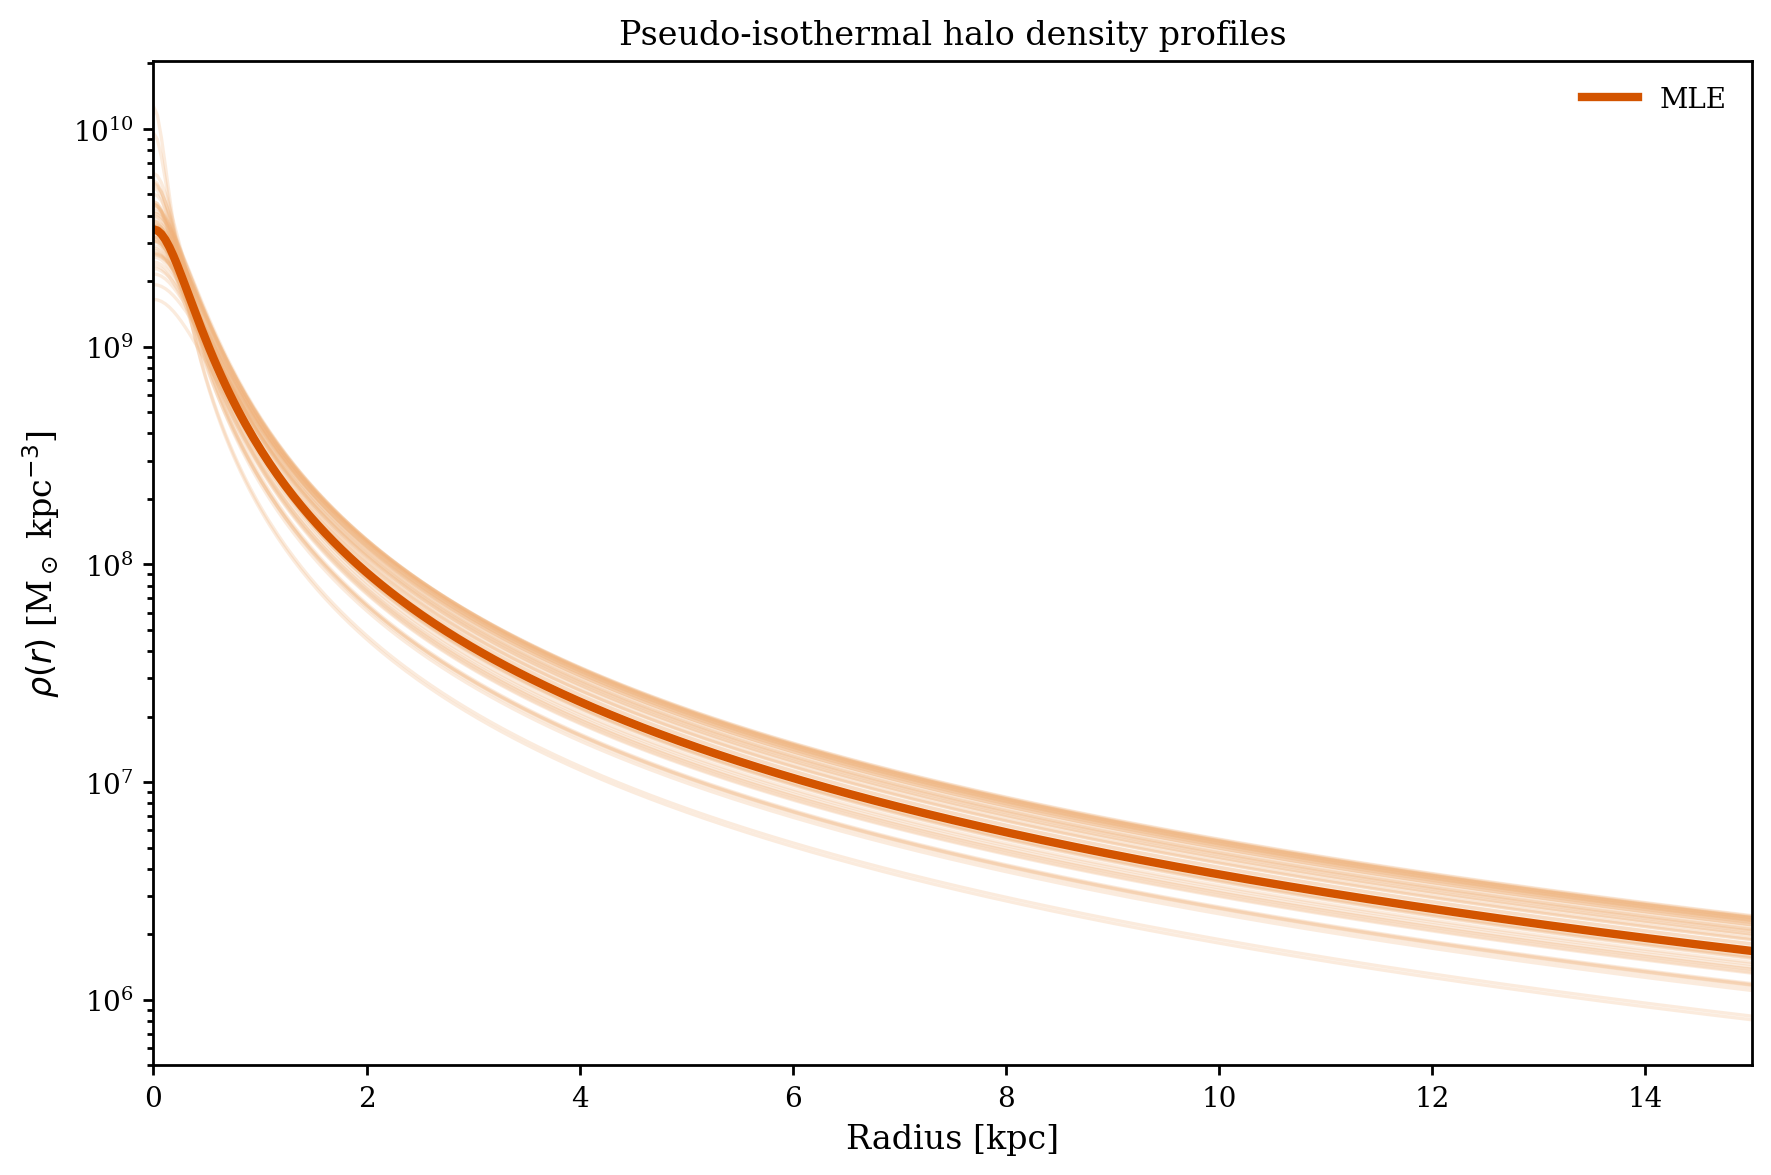

In [ ]:
print(
    f"rho0 MLE fit: V_d={rho_mle[0]:.1f} km/s, R_d={rho_mle[1]:.2f} kpc, "
    f"rho0={rho_mle[2]:.2e} Msun/kpc^3, R_h={rho_mle[3]:.2f} kpc"
)
print(f"Mean acceptance fraction: {rho_acceptance:.3f}")
print(f"Posterior sample shape: {rho_chain_flat.shape}")
print(f"MLE reduced chi^2: {rho_mle_reduced:.3f}")

rho_samples_with_chi2 = np.column_stack([rho_chain_flat, reduced_chi2_rho])

r_grid = np.linspace(0.0, 15.0, 400)
density_profiles = [
    sample[2] / (1.0 + (r_grid / sample[3]) ** 2) for sample in rho_chain_flat
]

fig, ax = plt.subplots(figsize=(9, 6))
for profile in density_profiles[:50]:
    ax.plot(r_grid, profile, color="#f0b27a", alpha=0.25, lw=1.2)

mle_profile = rho_mle[2] / (1.0 + (r_grid / rho_mle[3]) ** 2)
ax.plot(r_grid, mle_profile, color="#d35400", lw=3, label="MLE")

ax.set_xlabel("Radius [kpc]")
ax.set_ylabel(r"$\rho(r)$ [M$_\odot$ kpc$^{-3}$]")
ax.set_title("Pseudo-isothermal halo density profiles")
ax.set_yscale("log")
ax.set_xlim(0, 15)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

:::{tip} Extra Credit 3

We have used a simple model for the dark matter halo corresponding to an isothermal sphere. Fit a model corresponding to an NFW profile or an Einasto profile. 

Super bonus extra credit: estimate the masses of the halo and the disk. 

In [16]:
## Your extra credit code here 



:::{tip} Extra Credit 4

In the previous lab, we used a linear model to fit the light curve of a variable star. Use MCMC to fit this data, taking into account the observational uncertainty, with the period as a free parameter in the model. You could include Gaussian or Laplacian priors on the amplitudes to enforce sparsity. 

In [17]:
## Your extra credit code here 



ChatGPT link: 